In [21]:
import pandas as pd
from sklearn import preprocessing
from sklearn import tree
from sklearn.model_selection import train_test_split
import graphviz 
import warnings
import numpy as np
import sqlite3
import json
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, confusion_matrix, precision_score, recall_score, classification_report, accuracy_score
import joblib
from joblib import dump, load
from pathlib import Path

%matplotlib inline
warnings.filterwarnings('ignore')

In [22]:
f = Path("csvs/data.csv")
if not f.is_file():
    tmp = pd.read_csv('csvs/respuestas_encuestas.csv')
    data = tmp.astype(str).pivot_table(index="id_encuesta",columns="id_pregunta",values="respuesta",aggfunc=','.join)
    data.index = data.index.astype(int) #use astype to convert to int
    data.index.name = 'id'
    respuestas = pd.read_csv('csvs/encuestas.csv').set_index('id')
    data = data.join(respuestas, how='inner')
    data.rename(columns={'candidato': 'candidatoId'}, inplace=True)
    data.reset_index(level=0, inplace=True)
    data.to_csv(path_or_buf='csvs/data.csv')    
else:
    data = pd.read_csv('csvs/data.csv')
df = data
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,id,1,10,11,12,13,14,15,16,17,...,26,3,4,5,6,7,8,9,candidatoId,fecha
0,100,2,4,2,2,5,3,4,4,5,...,4,3,4,2,5,4,4,4,20,2019-02-07T18:17:25.611401
1,1000,2,3,3,3,4,3,4,3,5,...,4,2,3,3,5,5,4,4,9,2019-02-19T16:54:35.074392
2,100001,4,5,5,5,5,1,1,3,1,...,4,5,1,5,1,1,4,5,3,2019-02-21T15:56:04.223884
3,100006,4,1,5,1,5,5,5,4,5,...,5,5,5,5,5,5,2,4,4,2019-02-21T15:56:21.236512
4,100011,5,5,2,5,4,5,4,5,5,...,5,3,4,1,5,4,4,4,9,2019-02-21T15:56:46.090402


In [23]:
cand_data = json.loads(open('predictor_pol/candidatos.json','r').read())

In [24]:
def get_party(id):
    for p in cand_data:
        for c in p['candidates']:
            if c['id'] == id:
                return p['party']
    return 'n/a'

def get_name(id):
    for p in cand_data:
        for c in p['candidates']:
            if c['id'] == id:
                return c['name']
    return 'n/a'

In [25]:
df['partido'] = df.candidatoId.apply(get_party)
df['nombre'] = df.candidatoId.apply(get_name)

In [26]:
df.head(1)

,id,1,10,11,12,13,14,15,16,17,...,4,5,6,7,8,9,candidatoId,fecha,partido,nombre
0,100,2,4,2,2,5,3,4,4,5,...,4,2,5,4,4,4,20,2019-02-07T18:17:25.611401,Partido de la Gente,Edgardo Novick


In [27]:
print("cantidad de registros: {}".format(len(df)))

cantidad de registros: 28670


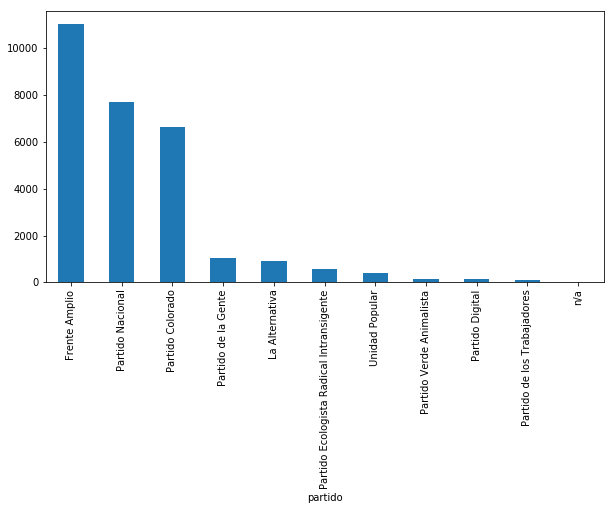

In [28]:
plt.rcParams['figure.figsize'] = [10, 5]
df.groupby('partido').size().sort_values(ascending=False).plot.bar()

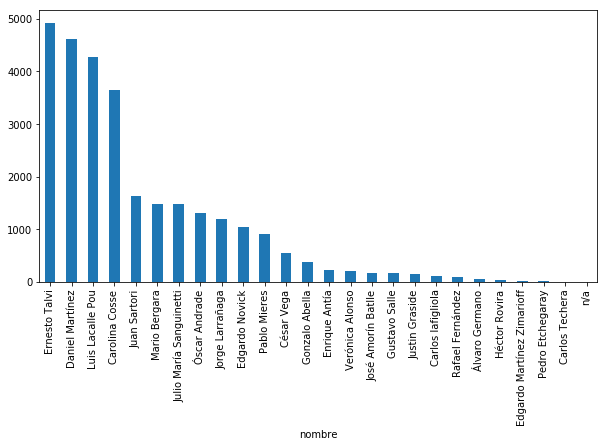

In [29]:
df.groupby('nombre').size().sort_values(ascending=False).plot.bar()

In [ ]:
#TODO hacer un poco mas de analisis exploratorio aca, me interesa estudiar por dia como fue la cantidad de participaciones
#agrupado por cada candidato

In [30]:
df.head()

,id,1,10,11,12,13,14,15,16,17,...,4,5,6,7,8,9,candidatoId,fecha,partido,nombre
0,100,2,4,2,2,5,3,4,4,5,...,4,2,5,4,4,4,20,2019-02-07T18:17:25.611401,Partido de la Gente,Edgardo Novick
1,1000,2,3,3,3,4,3,4,3,5,...,3,3,5,5,4,4,9,2019-02-19T16:54:35.074392,Partido Nacional,Luis Lacalle Pou
2,100001,4,5,5,5,5,1,1,3,1,...,1,5,1,1,4,5,3,2019-02-21T15:56:04.223884,Frente Amplio,Carolina Cosse
3,100006,4,1,5,1,5,5,5,4,5,...,5,5,5,5,2,4,4,2019-02-21T15:56:21.236512,Frente Amplio,Daniel Martínez
4,100011,5,5,2,5,4,5,4,5,5,...,4,1,5,4,4,4,9,2019-02-21T15:56:46.090402,Partido Nacional,Luis Lacalle Pou


In [32]:
features = ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '20', '21', '22', '23', '24', '25', '26', '3', '4', '5', '6', '7',
       '8', '9']

In [ ]:
#TODO estudiar si no conviene quitar los extremos: respuestas encuestas que suman 26 o las que suman 130
#hacer un grafico de barras de todo 1 o todo 5, si es muy heterogeneo el candidato , ensucian la data

In [33]:
from sklearn.linear_model import LogisticRegression

#Split train and test
df_train, df_test = train_test_split(df, test_size=0.20)

In [35]:
# Try to predict candidate
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',max_iter=700).fit(df_train[features], df_train.candidatoId)
df_test['predicted_candidate'] = clf.predict(df_test[features])

df_test['predicted_candidate'] = df_test['predicted_candidate'].apply(get_name)
df_test['candidato'] = df_test['candidatoId'].apply(get_name)


In [37]:
print(classification_report(df_test.nombre,df_test.predicted_candidate))
#TODO ver con DD que se puede concluir con esto

                            precision    recall  f1-score   support

         Carlos Iafigliola       0.00      0.00      0.00        25
            Carlos Techera       0.00      0.00      0.00         1
            Carolina Cosse       0.39      0.42      0.40       738
                César Vega       0.24      0.04      0.07       116
           Daniel Martínez       0.37      0.62      0.46       915
Edgardo Martínez Zimarioff       0.00      0.00      0.00         2
            Edgardo Novick       0.00      0.00      0.00       215
             Enrique Antía       0.00      0.00      0.00        46
             Ernesto Talvi       0.37      0.62      0.46       977
            Gonzalo Abella       0.32      0.09      0.15        74
             Gustavo Salle       0.00      0.00      0.00        33
             Héctor Rovira       0.00      0.00      0.00         2
           Jorge Larrañaga       0.20      0.00      0.01       229
        José Amorín Batlle       0.00      0.00

# Ahora probamos KNeighborsClassifier

In [39]:
n=22
k=22

pca = PCA(n_components=n)
pca.fit(df[features])
X = pca.transform(df[features])
y = df.candidatoId
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
candidate_model = KNeighborsClassifier(n_neighbors=n)
candidate_model.fit(X_train, y_train)
results = pd.DataFrame()
results['truth'] = y_test
results['truth'] = results.truth.apply(get_name)
results['prediction'] = candidate_model.predict(X_test)
results['prediction'] = results.prediction.apply(get_name)

print(classification_report(results.truth,results.prediction )) #TODO ver con DD conclusiones de esto

                            precision    recall  f1-score   support

         Carlos Iafigliola       0.00      0.00      0.00        24
            Carlos Techera       0.00      0.00      0.00         1
            Carolina Cosse       0.36      0.37      0.36       740
                César Vega       0.00      0.00      0.00        98
           Daniel Martínez       0.38      0.53      0.44       928
Edgardo Martínez Zimarioff       0.00      0.00      0.00         4
            Edgardo Novick       0.11      0.01      0.02       212
             Enrique Antía       0.00      0.00      0.00        42
             Ernesto Talvi       0.31      0.53      0.39       950
            Gonzalo Abella       0.67      0.07      0.13        80
             Gustavo Salle       0.00      0.00      0.00        31
             Héctor Rovira       0.00      0.00      0.00        12
           Jorge Larrañaga       0.05      0.00      0.01       247
        José Amorín Batlle       0.00      0.00

In [40]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_train ,feature_names = features) #TODO fix

ModuleNotFoundError: No module named 'lime'

In [41]:
exp = explainer.explain_instance(df_test[[features]][0], clf.predict_proba, num_features=2, top_labels=1)

NameError: name 'explainer' is not defined